In [13]:
import torch
from matplotlib import pyplot as plt

from survae import SurVAE
from survae.calibrate import calc_cs, plot_histogram, plot_cdf
from survae.data import checkerboard, ngon, circles, corners, Dataset, spatial_mnist
from survae.layer import BijectiveLayer, AbsoluteUnit, OrthonormalLayer, SortingLayer
from survae.plot import plot_models, plot_q_values, plot_losses
from survae.train import train_models

In [14]:
default_model_generators = [
    lambda c: SurVAE(
        [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(10)
        ],
        name="NF",
        condition_size=c,
    ),
    lambda c: SurVAE(
        [
            AbsoluteUnit(torch.tensor([1 / 2, 1 / 2])),
        ] + [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(10)
        ],
        name="NF-abs",
        condition_size=c,
    ),
    lambda c: SurVAE(
        [
            AbsoluteUnit(torch.tensor([1 / 2, 1 / 2]), learn_q=True),
        ] + [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(10)
        ],
        name="NF-abs-trained",
        condition_size=c,
    )
]

In [15]:
default_datasets = [
    Dataset(ngon, name="N-gon"),
    Dataset(circles, name="Circles"),
    Dataset(corners, name="Corners"),
    Dataset(checkerboard, name="Checkerboard"),
]

In [16]:
models = train_models(default_model_generators, default_datasets, epochs=10)

100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


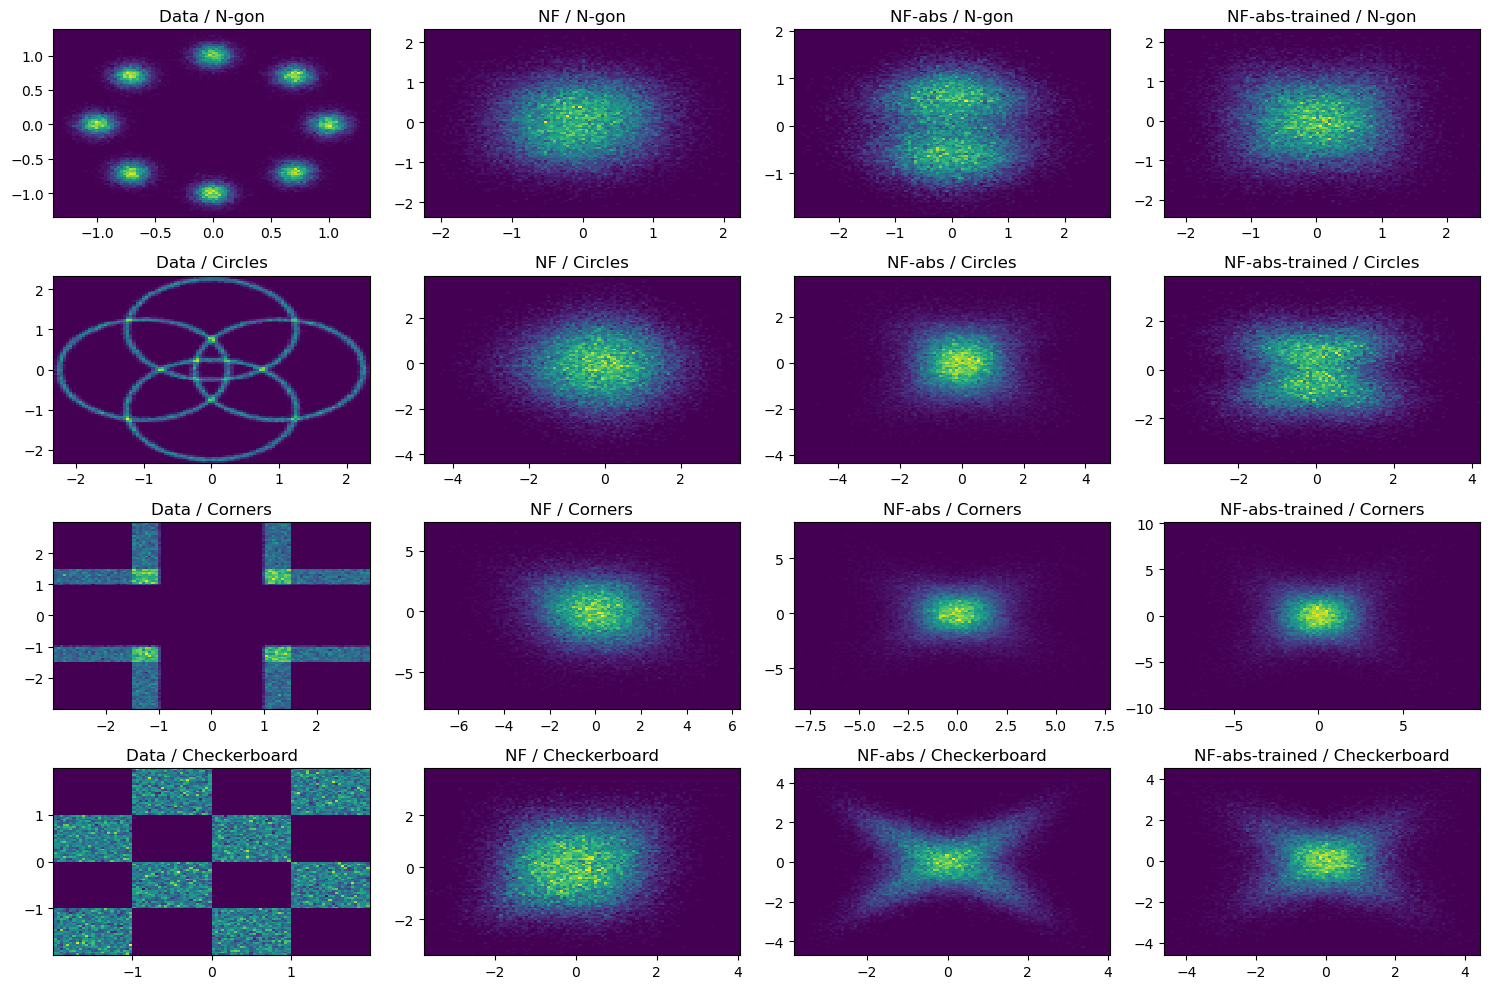

In [17]:
plot_models(models, default_datasets)

As we can see, the performance for symmetric datasets of NF+abs is much better, whereas the performance for antisymmetric is terrible.

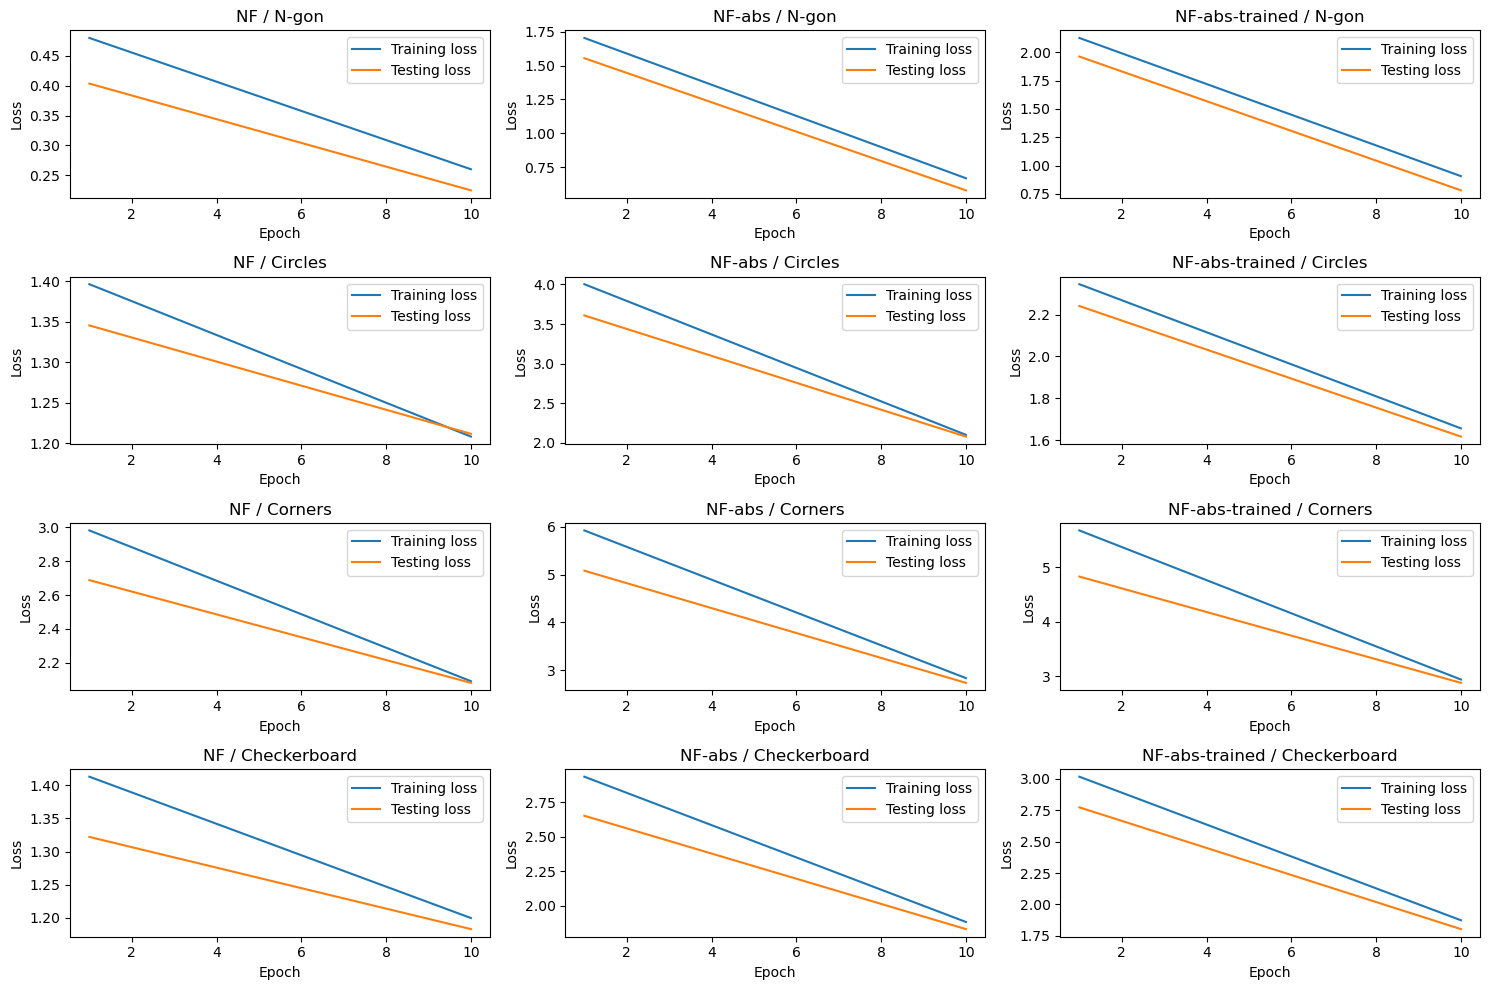

In [18]:
plot_losses(models, default_datasets)

When looking at the ending losses, the plots reflect the observations above - the absolute layer is great for symmetric data but terrible for non-symmetric data.

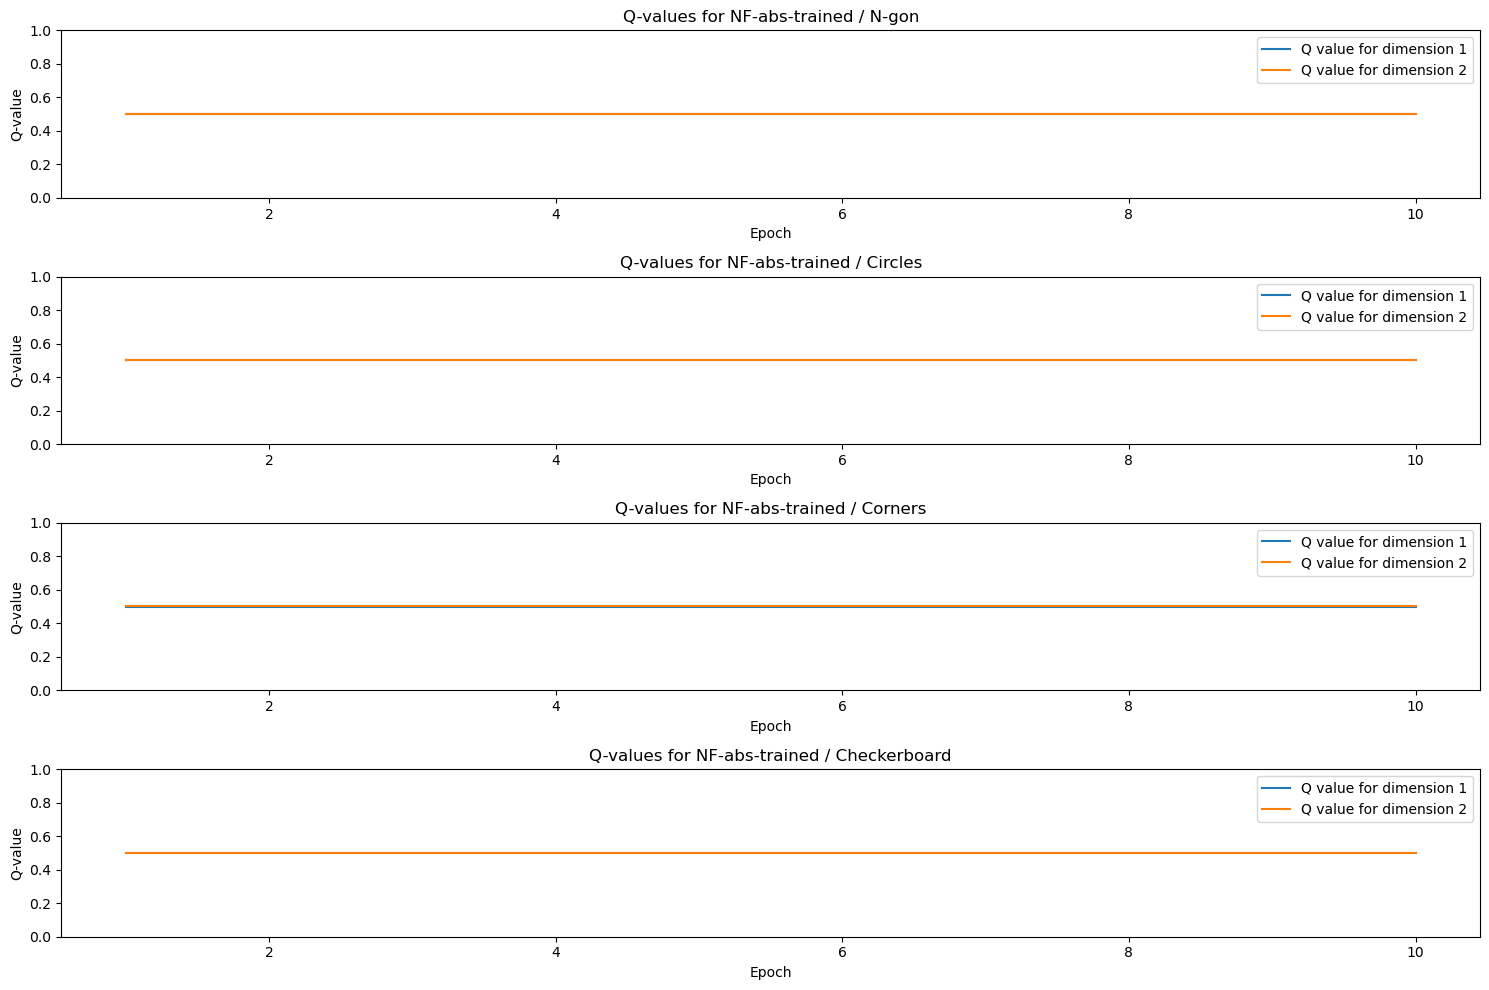

In [19]:
plot_q_values(models, default_datasets)

The Q-values for the absolute layer that influence the percentage of flipped values stay at 0.5, which makes sense since bot the symmetric/antisymmetric datasets are perfectly symmetric/antisymmetric.

To test whether the Q-values will be correctly learned for skewed data, we can modify the datasets to randomly `abs()` values in a given axis.

# Skewed Datasets

In [20]:
skewed_datasets = [
    Dataset(ngon, name="Skewed N-gon").skew(),
    Dataset(circles, name="Skewed Circles").skew(),
    Dataset(corners, name="Skewed Corners").skew(),
    Dataset(checkerboard, name="Skewed Checkerboard").skew(),
]

In [22]:
models = train_models(default_model_generators, skewed_datasets, epochs=10)

100%|██████████| 12/12 [00:07<00:00,  1.67it/s]


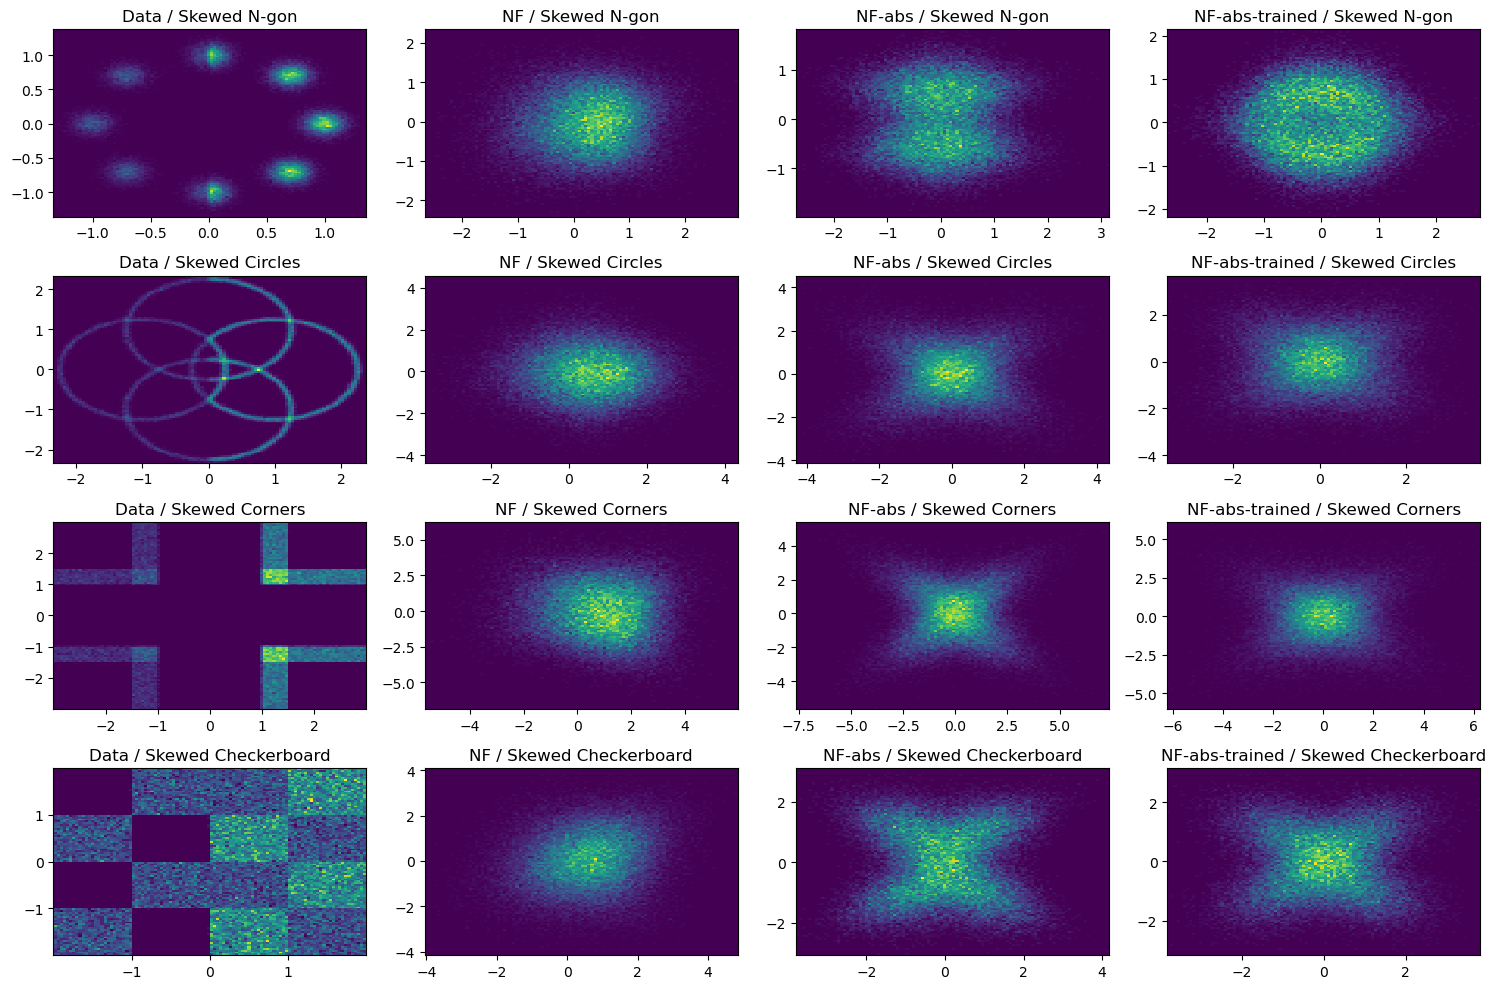

In [23]:
plot_models(models, skewed_datasets)

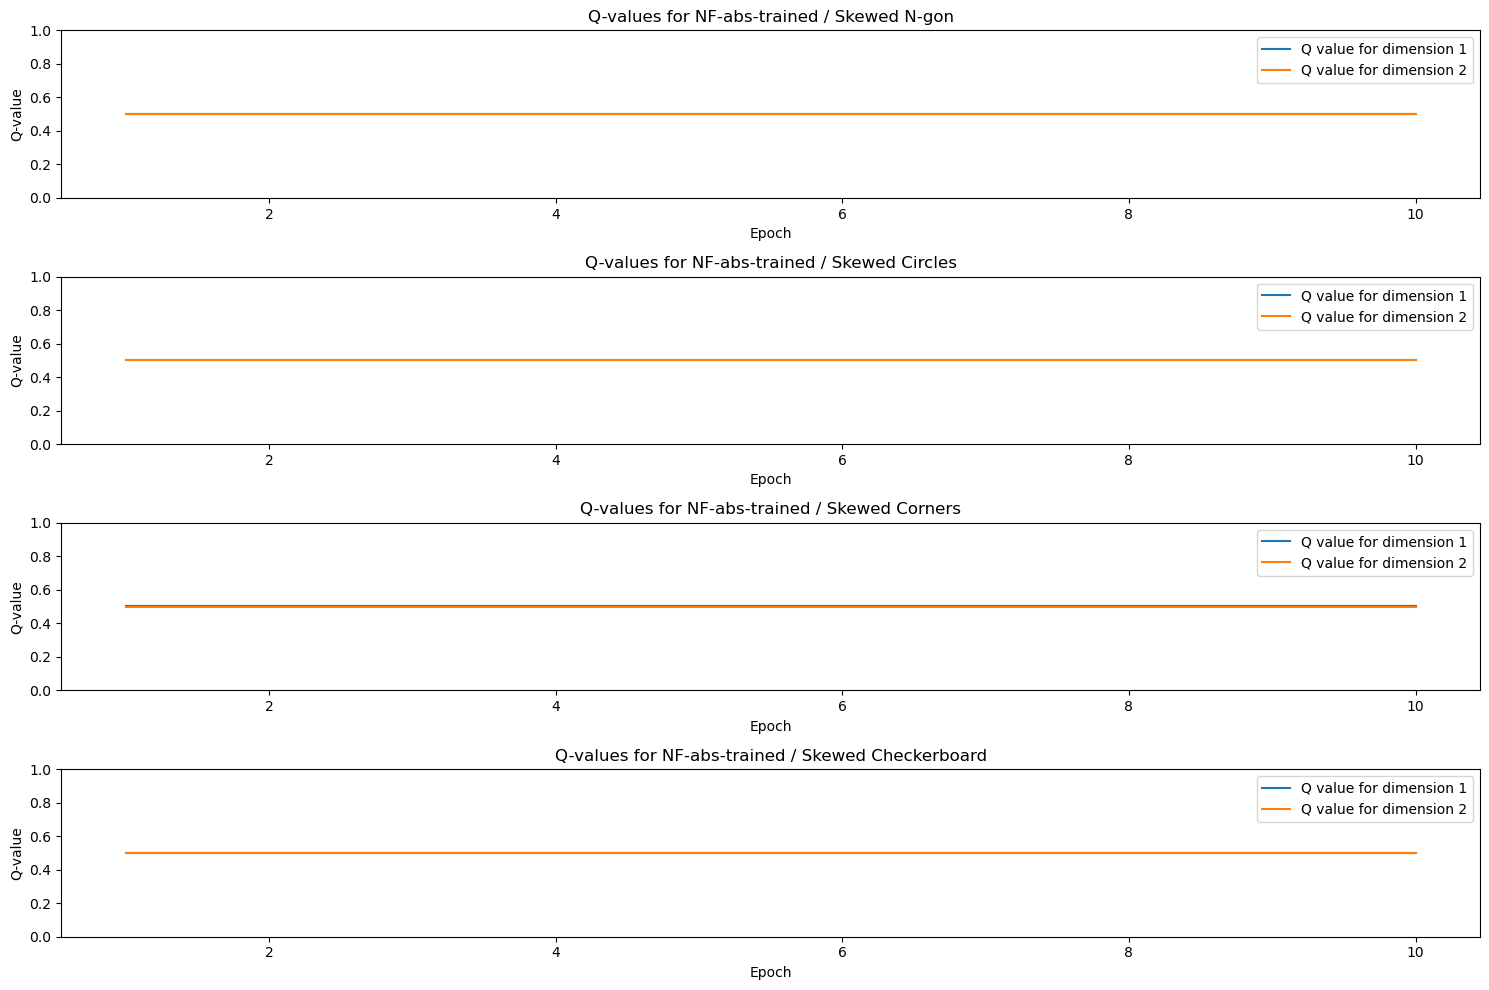

In [24]:
plot_q_values(models, skewed_datasets)

With the skew being 0.5, we move half of the data to the positive side, meaning that the split is 1/4 negative and 3/4 positive. This justifies the Q-value of 0.75.

# Calibration

In [25]:
# TODO: do something with me
model = models[0, 0][0]

In [26]:
X_test = model.sample(100)
cs = calc_cs(model, X_test, 50)

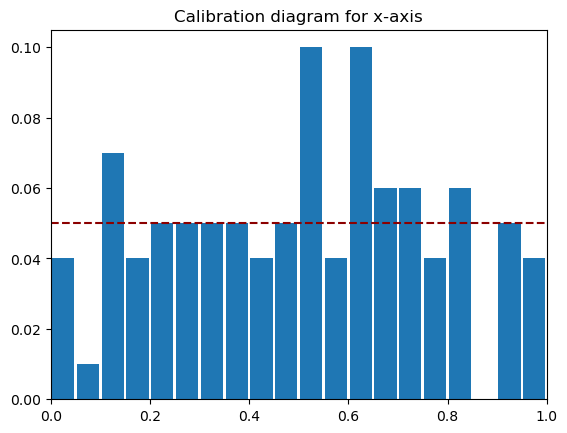

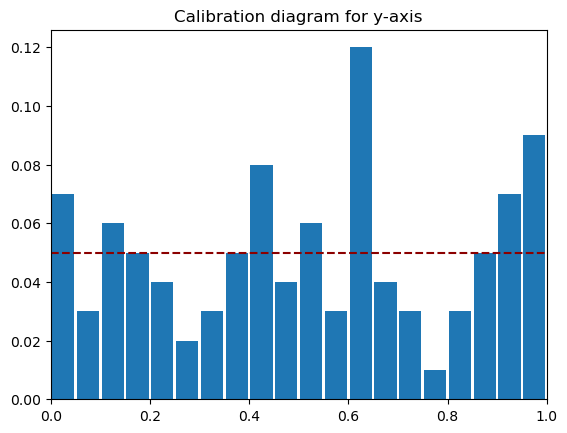

In [27]:
plot_histogram(cs[0], 20, "Calibration diagram for x-axis")
plot_histogram(cs[1], 20, "Calibration diagram for y-axis")

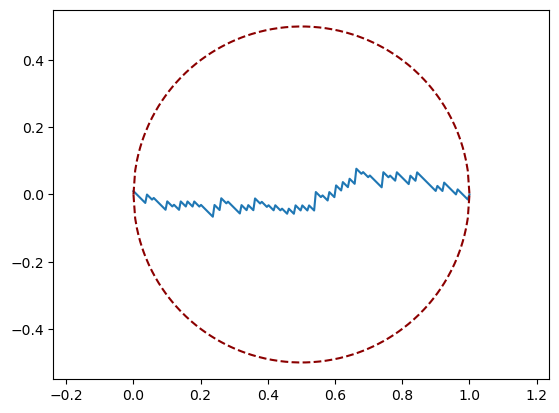

In [28]:
plot_cdf(cs[0])

# Offset Datasets

Offsetting the datasets breaks the current network structure because the absolute layer is at the very beginning.

In [29]:
vector = torch.tensor([1, 2])

offset_datasets = [
    Dataset(ngon, name="Offset N-gon").offset(vector),
    Dataset(circles, name="Offset Circles").offset(vector),
    Dataset(corners, name="Offset Corners").offset(vector),
    Dataset(checkerboard, name="Offset Checkerboard").offset(vector),
]

In [30]:
models = train_models(default_model_generators, offset_datasets, epochs=10)

100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


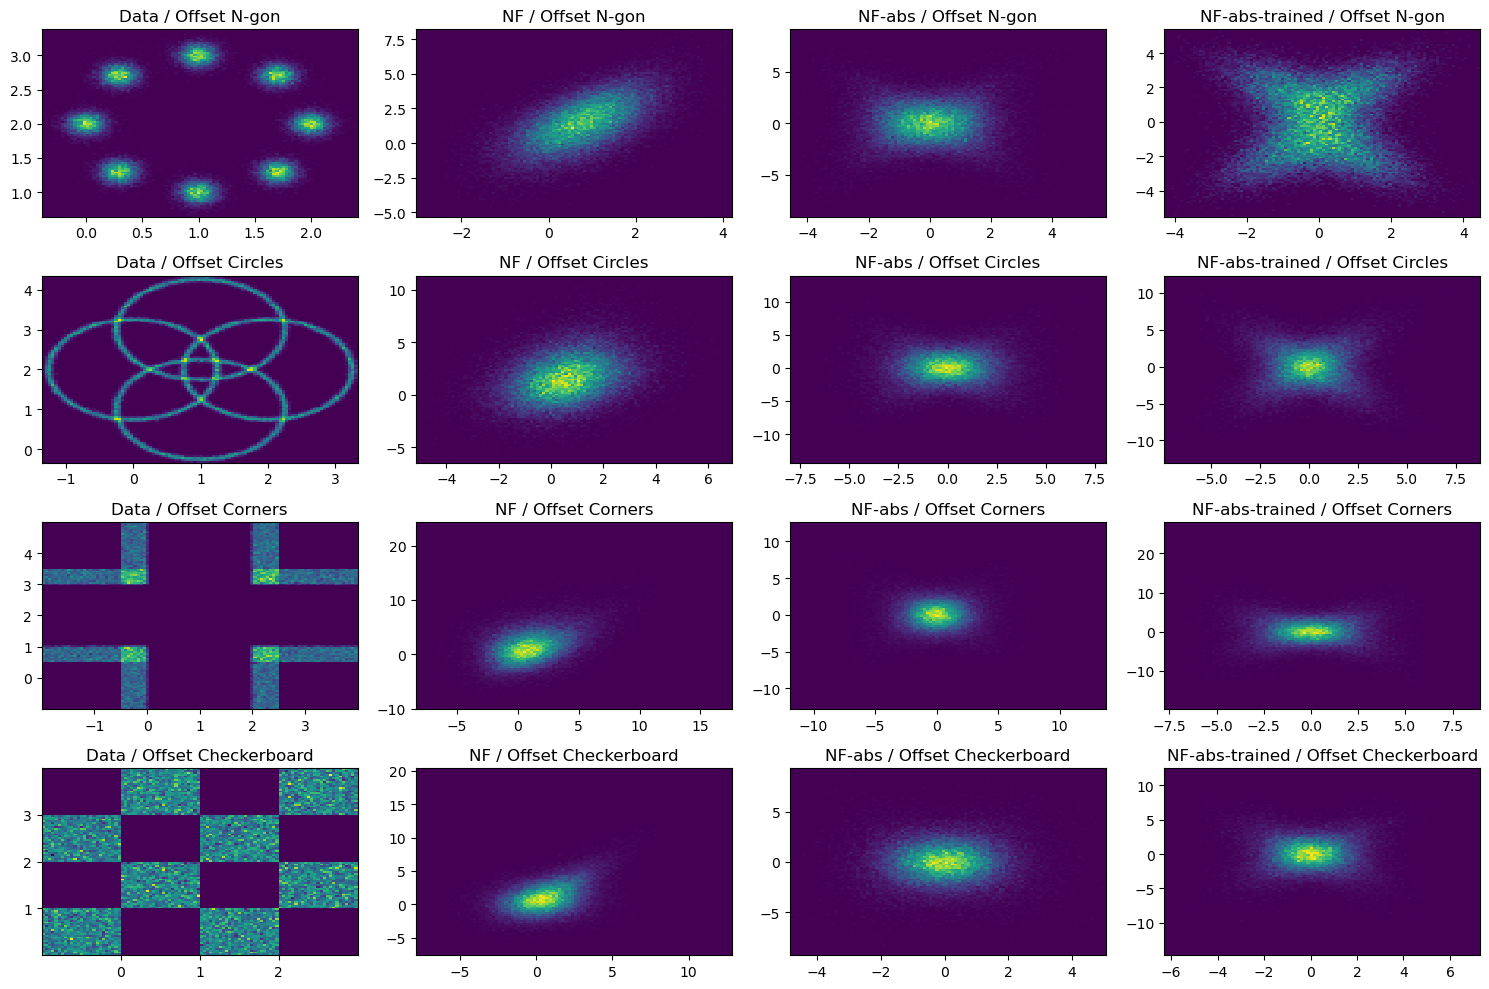

In [31]:
plot_models(models, offset_datasets)

To fix this, we can change the structure by moving it in the middle and let the bijective layers handle the transformation.

In [ ]:
middle_abs_model_generators = [
    lambda: SurVAE(
        [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(10)
        ],
        name="NF",
    ),
    lambda: SurVAE(
        [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(5)
        ] + [
            AbsoluteUnit(torch.tensor([1 / 2, 1 / 2])),
        ] + [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(5)
        ],
        name="NF-middle-abs",
    ),
    lambda: SurVAE(
        [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(5)
        ] + [
            AbsoluteUnit(torch.tensor([1 / 2, 1 / 2]), learn_q=True),
        ] + [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(5)
        ],
        name="NF-middle-abs-trained",
    )
]

In [ ]:
models = train_models(middle_abs_model_generators, offset_datasets)

In [ ]:
plot_models(models, offset_datasets)

In [ ]:
plot_losses(models, offset_datasets)

In [ ]:
plot_q_values(models, offset_datasets)

Here it's interesting to visualize the symmetry axes.

In [ ]:
# TODO: ended here

last_models = [models[i, len(middle_model_names)-1][0] for i in range(len(offset_dataset_names))]

n_models = len(last_models)

n_cols = 2  # set manually
n_rows = n_models // n_cols

axis_len = 8  # sample length for axis visualization
axis_n_samples = 10_000  # number of samples per axis
distr_n_samples = 100_000  # number of samples for distribution

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for i in range(n_models):
    model = last_models[i]
    k = i // n_cols

    with torch.no_grad():
        samples = model.sample(distr_n_samples).cpu().numpy()

        _axis = torch.linspace(-axis_len, axis_len, axis_n_samples)
        _zeros = torch.zeros(axis_n_samples)

        x_axis = torch.stack((_axis, _zeros), dim=1)
        y_axis = torch.stack((_zeros, _axis), dim=1)

        for layer in reversed(model.layers[:9]):
            x_axis = layer.backward(x_axis)
            y_axis = layer.backward(y_axis)

    x_axis = x_axis.cpu()
    y_axis = y_axis.cpu()

    # choose right subfigure
    if n_cols == 1 and n_rows == 1:
        _ax = ax
    elif n_cols == 1 or n_rows == 1:
        _ax = ax[max(k, i % n_cols)]
    else:
        _ax = ax[k, i % n_cols]

    _ax.hist2d(samples[:, 0], samples[:, 1], bins=100)
    _ax.scatter(x_axis[:, 0], x_axis[:, 1], s=1, c="red")
    _ax.scatter(y_axis[:, 0], y_axis[:, 1], s=1, c="yellow")

    _ax.set_xlim(-2.5, 2.5)
    _ax.set_ylim(-2.5, 2.5)
    _ax.set_aspect("equal")

    _ax.set_xticks([])
    _ax.set_yticks([])

plt.tight_layout()
plt.show()

# Spatial MNIST

In [ ]:
smnist_model_generators = [
    lambda: SurVAE(
        [
            [BijectiveLayer(100, [64] * 5), OrthonormalLayer(100)]
            for _ in range(20)
        ],
        name="NF",
    ),
    lambda: SurVAE(
        [
            [BijectiveLayer(100, [64] * 5), OrthonormalLayer(100)]
            for _ in range(10)
        ] + [
            SortingLayer(),
        ] + [
            [BijectiveLayer(100, [64] * 5), OrthonormalLayer(100)]
            for _ in range(9)
        ],
        name="NF-sorting",
    ),
]

In [ ]:
# TODO: little hacky, fixme
EPOCHS *= 20
models = train_models(smnist_model_generators, [Dataset(spatial_mnist)])
EPOCHS //= 20

In [ ]:
rows = 4 * (1 + len(smnist_model_generators))
columns = 10
smnist = spatial_mnist(rows * columns)

# Plot the first k*l images with sampled points in a 2D grid
fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15, 10))

for i in range(rows):
    for j in range(columns):
        if i // 4 == 0:
            sample = smnist[i * columns + j]
        elif i // 4 == 1:
            sample = models[0,0][0].sample(1)[0]
        elif i // 4 == 2:
            sample = models[0,1][0].sample(1)[0]
        else:
            raise Exception("Should not have happened!")

        ax = axes[i, j]
        points = sample.cpu().numpy().reshape(50, 2)

        ax.scatter(points[:, 0], -points[:, 1], s=15, label='Sampled Points')

        ax.axis('off')
        ax.set_aspect('equal')

plt.show()

# Visualizing symmetry lines

## Checkerboard

In [ ]:
model_generator = lambda: SurVAE(
    [
        [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2), ]
        for _ in range(6)
    ] + [
        [AbsoluteUnit, [1 / 2], {'learn_q': True}],
    ] + [
        [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2), ]
        for _ in range(6)
    ],
)

In [ ]:
models = [model_generator() for _ in range(4)]

In [ ]:
for model in models:
    model.train(checkerboard, epochs=100)

In [ ]:
n_models = len(models)

n_cols = 2  # set manually
n_rows = n_models // n_cols

axis_len = 8  # sample length for axis visualization
axis_n_samples = 10_000  # number of samples per axis
distr_n_samples = 100_000  # number of samples for distribution

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for i in range(n_models):
    model = models[i]
    k = i // n_cols

    with torch.no_grad():
        samples = model.sample(distr_n_samples).cpu().numpy()

        _axis = torch.linspace(-axis_len, axis_len, axis_n_samples)
        _zeros = torch.zeros(axis_n_samples)

        x_axis = torch.stack((_axis, _zeros), dim=1)
        y_axis = torch.stack((_zeros, _axis), dim=1)

        for layer in reversed(model.layers[:9]):
            x_axis = layer.backward(x_axis)
            y_axis = layer.backward(y_axis)

    x_axis = x_axis.cpu()
    y_axis = y_axis.cpu()

    # choose right subfigure
    if n_cols == 1 and n_rows == 1:
        _ax = ax
    elif n_cols == 1 or n_rows == 1:
        _ax = ax[max(k, i % n_cols)]
    else:
        _ax = ax[k, i % n_cols]

    _ax.hist2d(samples[:, 0], samples[:, 1], bins=100)
    _ax.scatter(x_axis[:, 0], x_axis[:, 1], s=1, c="red")
    _ax.scatter(y_axis[:, 0], y_axis[:, 1], s=1, c="yellow")

    _ax.set_xlim(-2.5, 2.5)
    _ax.set_ylim(-2.5, 2.5)
    _ax.set_aspect("equal")

    _ax.set_xticks([])
    _ax.set_yticks([])

plt.tight_layout()
plt.show()

## Other patterns TODO